# Workshop KI und Ethik
## Case Study 'Vorhersage Zulassung Workshop Teilnehmende'

### Zusammenfassung

Dieses Jupyter-Notebook ist eine umfassende Fallstudie zum Thema "KI und Ethik". Der Inhalt des Notebooks ist wie folgt:

1. **Einführung**: Das Notebook beginnt mit einer Einführung in die Fallstudie.
3. **Datengenerierung und -kennzeichnung**: Das Notebook importiert notwendige Bibliotheken und definiert Funktionen zur Generierung eines Datensatzes und zur Kennzeichnung desselben mit einem Entscheidungsbaum.
4. **Datenbeschreibung und -visualisierung**: Der generierte Datensatz der Workshop-Teilnehmer wird beschrieben und visualisiert.
5. **Modelltraining**: Der Datensatz wird in Trainings- und Testsets aufgeteilt und ein neuronales Netzwerkmodell wird trainiert.
6. **Modellevaluierung**: Die Leistung des Modells wird anhand von Metriken wie Genauigkeit, Präzision und Recall bewertet.
7. **Leistungsanalyse**: Die Leistung des Modells wird weiterhin mit einer Konfusionsmatrix und Visualisierungen analysiert.
8. **Korrelationsanalyse**: Das Notebook untersucht Korrelationen zwischen Geschlecht, Punktzahl und Zulassungsentscheidungen.
9. **Fairness-Metriken**: Fairness-Metriken wie statistische Paritätsdifferenz und disparater Einfluss werden berechnet und diskutiert.

Das Hauptziel dieses Notebooks besteht darin, das Potenzial für Bias in maschinellen Lernmodellen aufzuzeigen und die Bedeutung der Berücksichtigung von Fairness und Ethik in KI-Anwendungen zu betonen.

## 1. Einführung Fallstudie

### Imaginäres Szenario

- Stellt euch vor, dass wir diesen Workshop schon fast hundert Mal durchgeführt haben. 

- Die Workshops waren immer ein großer Erfolg!!

- Gleichzeitig konnten wir nicht immer alle zulassen und haben uns entscheiden müssen, wer am Workshop teilnehmen darf.

- Dafür haben wir einen Vortest geschaffen, Daten über die potenziellen Teilnehmenden gesammelt (ohne Namen, weshalb dies nach der heutigen DSGVO kein Problem darstellt) und jeweils 20 Teilnehmende zugelassen.

- Nun, da wir mehr als 4000 Daten von Studierenden haben, dachten wir uns, dass es schlau wäre, den Entscheidungsprozess zu automatisieren.

- Deshalb haben wir auf den Daten ein Neuronales Netzwerk trainiert, dass uns diese Entscheidung abnimmt!

- Bisher dachten wir, dass wir ziemlich objektiv und nur dem Vortest nach entschieden haben.

- Wir überprüfen unsere Biases im Folgenden und schauen, ob und inwiefern das Neuronale Netz diese Biases übernimmt, verstärkt und wie wir sie (möglicherweise) reduzieren können.

## 2. Paketinstallation 

Hier werden die benötigten Bibliotheken installiert und importiert.

In [219]:
#pip install aif360

In [220]:
#pip install aif360[LawSchoolGPA]


In [221]:
#pip install aif360[Reductions]

In [222]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
import matplotlib.ticker as ticker

## 3. Datengenerierung und -kennzeichnung

Hier wird unserer biased Entscheidungsbaum gelernt. Die Testergebnisse (scores) sind natürlich wichtig, aber mit unserem verzerrten Denken, haben wir unsere Entscheidungen unterbewusst leider noch auf andere Attribute gelegt. 

In [223]:
def decisiontree(feature): #score hinzufügen korrigiert mit geschlecht, religion, income

  """
  MAPPING

  The position in the array indicates the number in the map
  gender = [male, female, non-binary, other]
  religion = [none, christian, muslim, jew, hindi, other]
  study_field = [natural sciences, formal sciences, arts & humanities, social sciences, other]
  BA/MA = [BA, MA]

  INPUT: array with features
  OUTPUT: label for each array entry

  """
  score = feature[7]
  if feature[0] > 2 and score < 80: #people of non-binary or other gender excluded for a score less than 80%
    return 0
  elif feature[0] > 1 and score < 50: #people of female gender excluded for a score less than 50%
    return 0
  elif feature[0] == 0 and score > 20: #people of male gender inluded for a score more than 20%
    return 1
  elif feature[1] < 15 or feature[1] >55 and score < 80: #old and young people excluded for a score less than 95%
    return 0
  elif feature[2] > 3 and score < 80: # people of other religiones than none, christian and mulsim excluded for a score less than 80%
    return 0
  elif feature[3] < 800 and score < 95 : #people with less income than 800€ per month excluded for a score less than 95%
    return 0
  elif feature[4] > 2: #people of other studyfields than natural and formal sciences excluded for a
    return 0
  elif feature[6] == 0 and feature[5] < 3 and score < 50: #BA students under 3rd semester excluded for score less than 50%
    return 0
  elif score < 25 : #people with a score less than 25% excluded
    return 0
  else:
    return 1


Hier werden zufällig Studierende generiert mit unterschiedlichen Merkmalen nach bestimmten Verteilungen (z.B. Normalverteilung oder Gleichverteilt).

Damit werden wir unsere tausende Trainings-Studierende generieren.

In [224]:
def create_random_students(n, feats):
  """
  creates an example student with the paramters [[gender, age, religion, income, study field, semester, BA/MA], label]
  """
  s = np.zeros((len(feats),n))

  s[0] = np.random.choice(4, n, p=[0.4, 0.4, 0.15, 0.05]).astype(int) #add gender
  s[1] = np.round(np.absolute(np.random.normal(25,5,n))).astype(int) #add age
  s[2] = np.random.choice(6, n, p=[0.4, 0.3, 0.1, 0.1, 0.05, 0.05]).astype(int) #add religion
  s[3] = np.round(np.absolute(np.random.normal(1400,500,n))).astype(int) #add income
  s[4] = np.random.randint(6, size = n) # add study field
  s[5] = np.round(np.absolute(np.random.normal(6,2,n))).astype(int) #add semester
  s[6] = np.random.randint(2, size = n) #add BA/MA
  s[7] = np.random.randint(100, size = n) #add score
  s[8] = np.array([decisiontree(s_i) for s_i in s[0:8].T]).astype(int)

  df = pd.DataFrame(s.T.astype(int), columns=feats)

  return df

Diese Attribute haben die Studierenden

In [225]:
feats = ['gender', 'age', 'religion', 'income', 'study field', 'semester', 'BA/MA', 'score', 'label']

## 4. Datenbeschreibung und -visualisierung

Die durch den 'Decision Tree' geschafenen Daten sind 'synthetische Daten', also Daten, die keine wirkliche Phänomene in der Welt darstellen. Sie sind Daten, die wir für euch geschaffen haben, damit ihr nachvollziehen könnt, wie Bias in ML auftreten kann. Die Zahlen sind jeweils den Strings (Text) zugeordnet, da die Algorithmen nur mit Zahlen rechnen können. 

Zuerst erstellen wir zufällige Studierende, die nach bestimmten Verteilungen (wie z.B. Normalverteilung) generiert werden. Dabei wird nach dem Entscheidungsbaum jeder Studierenden ein zufälliges Label je nach Score und anderen Attributen vergeben.

In [226]:
dic_gender = {'male' : 0, 'female': 1, 'nonbinary': 2, 'other': 3}
dic_religion = {'none': 0, 'christian': 1, 'muslim': 2, 'jew': 3, 'hindi': 4, 'other': 5}
dic_studyfield = {'natural sciences' : 0, 'formal sciences' : 1, 'arts & humanities' : 2, 'social sciences' : 3, 'other' : 4}
dic_BA = {'BA': 0, 'MA':1}

Hier werden n (n=8000) Studierende erstellt und die ersten 4 dargestellt. Label ist die Entscheidung, ob die Person zugelassen wurde

In [227]:
n = 8*10**4
df = create_random_students(n, feats)
df.head(4)

,gender,age,religion,income,study field,semester,BA/MA,score,label
0,1,19,0,1355,3,4,0,48,0
1,0,17,2,1094,1,8,0,50,1
2,1,26,0,1644,2,8,1,39,1
3,2,28,0,1688,5,9,0,37,0


Wir schauen uns pro Attribut den Durschnitt, die Varianz und min und max an.

In [228]:
df.describe()[:5]

,gender,age,religion,income,study field,semester,BA/MA,score,label
count,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.854625,25.012687,1.253125,1399.65230,2.488713,6.001087,0.501375,49.456587,0.472488
std,0.855731,4.999784,1.441363,498.08359,1.712348,2.016157,0.500001,28.832290,0.499246
min,0.000000,5.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,1061.00000,1.000000,5.000000,0.000000,24.000000,0.000000


In [229]:
def train_test_split_NN(df, feats):
    X = df[feats[:-1]]
    y = df[feats[-1]]
    return train_test_split(X, y, test_size=0.2)

## 5. Modelltraining

Um das neuronale Netz zu trainieren und die Genauigkeit der Vorhersagen zu überprüfen werden 
1. Die oben erstellten Daten wurden in **Trainings- und Tesdaten** aufgeteilt. 
2. Durch die Funktion '**MLP Classifier**' wird mit den Trainingsdaten das neuronale Netzwerk trainiert. Anschließend werden für die Testdaten durch das neuronale Netz Label voraussgesagt. 
3. Es wird überprüft, wie viele der vorausgesagten Label mit den bekannten Labeln der Testdaten übereinstimmen, um die Genaugkeit des NN zu bestimmen.

In [230]:
# 1. Aufteilen der Daten in Trainings- und Tesdaten

X_train, X_test, y_train, y_test = train_test_split_NN(df, feats)

In [231]:
# 2. Trainieren der NN um ein Label vorherzusagen

def train_NN(X,y):
  """
  INPUT: dataframe with features and labels, list of features
  OUTPUT: trained model
  """
  model = MLPClassifier(hidden_layer_sizes=(50, ), max_iter=200, random_state=42)
  model.fit(X, y)
  return model

In [232]:
def NN(X_train, X_test, y_train, y_test):
    model = train_NN(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return model, X_train, X_test, y_train, y_test, y_pred

## 6. Modellevaluierung
Hier wird das Modell trainiert und die accuracy, recall und precision ausgegeben.

In [233]:
# 3. Ausführen des NN
model = NN(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      8458
           1       0.88      0.97      0.92      7542

    accuracy                           0.92     16000
   macro avg       0.93      0.93      0.92     16000
weighted avg       0.93      0.92      0.92     16000



In [234]:
#Needs to be defined in Workshop (here test_data used to see if it is running)
student_x = X_test
student_y = y_test
print(student_x.head(4))

       gender  age  religion  income  study field  semester  BA/MA  score
34949       1   27         4     667            5         7      1     33
75491       1   29         3    1450            0         3      1     44
38191       0   27         5     388            1         6      1     24
37603       2   21         1     129            0         7      1     53


In [235]:
def transform_magnitudes_to_letters(number,pos):
    magnitude = 0
    while abs(number) >= 1000:
        magnitude += 1
        number /= 1000.0
    return '%i%s' % (number, ['', 'K', 'M'][magnitude])

## Modellevaluierung

In [236]:
def graphs():
    fig, axs = plt.subplots(2, 2, figsize = (16,8))
    gender = list(student_x.iloc[:,0])
    y = [gender.count(0), gender.count(1), gender.count(2), gender.count(3)]
    gender_labels = ['male', 'female', 'nonbinary', 'other']

    axs[0,0].set_title("Analysis of people admitted to the workshop")
    axs[0,0].bar(gender_labels, y)
    axs[0,0].set_xlabel("Gender of people admitted to the workshop")
    axs[0,0].set_ylabel("Number of people")
    axs[0,0].yaxis.set_major_formatter(ticker.FuncFormatter(transform_magnitudes_to_letters))

    label = list(student_y)
    y = [label.count(0), label.count(1)]
    x = ['pass', 'fail']

    axs[0,1].bar(x, y, width=0.4)
    axs[0,1].set_xlabel("Success in workshop")
    axs[0,1].set_ylabel("Number of people")
    axs[0,1].yaxis.set_major_formatter(ticker.FuncFormatter(transform_magnitudes_to_letters))

    df.groupby('label').gender.value_counts().unstack().plot.bar(ax = axs[1,0])
    axs[1,0].set_xlabel("Success in workshop")
    axs[1,0].set_ylabel("Number of people")
    axs[1,0].legend(labels=gender_labels)
    axs[1,0].yaxis.set_major_formatter(ticker.FuncFormatter(transform_magnitudes_to_letters))



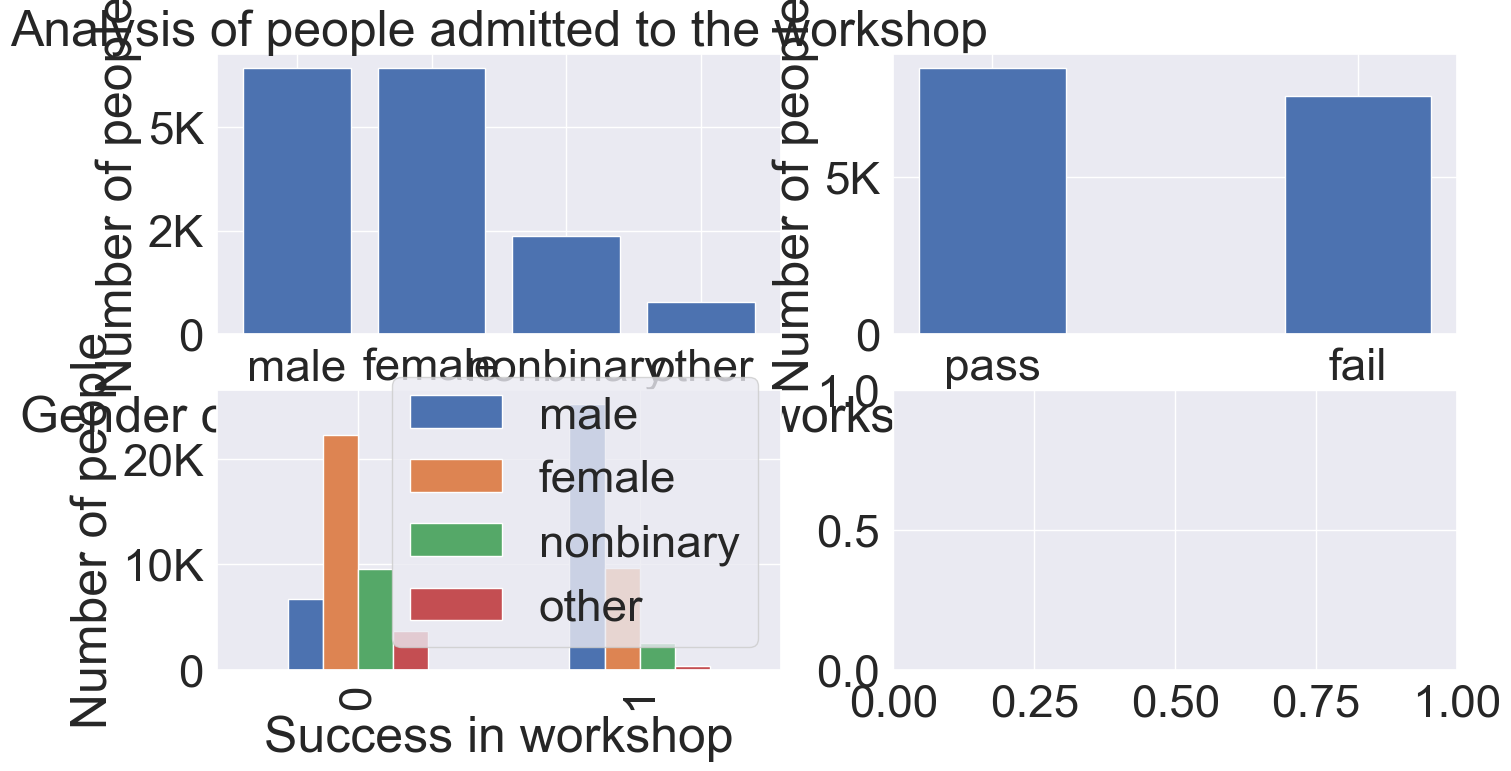

In [237]:
graphs()

## Korrelationen zwischen Gender, score und Entscheidung für Zulassung



In [238]:
corr = df[['gender', 'score', 'label']].corr()
corr.style.background_gradient(cmap='coolwarm')

,gender,score,label
gender,1.000000,-0.002137,-0.480349
score,-0.002137,1.000000,0.414212
label,-0.480349,0.414212,1.000000


## Konfusionsmatrix


In [239]:
#y_pred = train_NN(X_train, y_train).predict(X_test)
y_pred = model[5]
lmod = model[0]

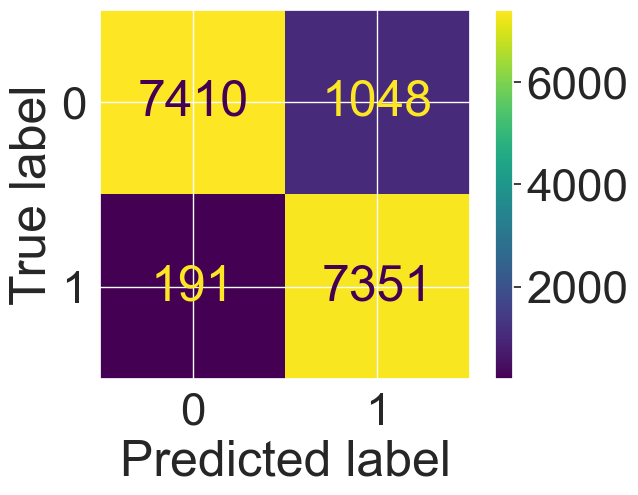

In [240]:
# In Folien
#sns.set(font_scale=1)
cm = confusion_matrix(y_test, y_pred, labels=lmod.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lmod.classes_)

disp.plot()
plt.show()

In [241]:
metrics.accuracy_score(y_test, y_pred)

0.9225625

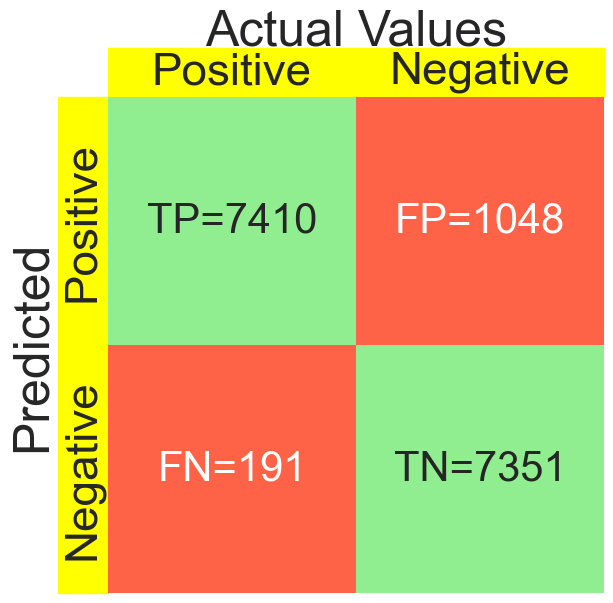

In [242]:
#Helper snipet for labeling axes of confusion matrix
sns.set(font_scale=3)
plt.figure(figsize=(7, 7))
ax = sns.heatmap(data=[[1, 0], [0, 1]], cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True),
                 annot=[[f"TP={cm[0][0]:.0f}", f"FP={cm[0][1]:.0f}"], [f"FN={cm[1][0]:.0f}", f"TN={cm[1][1]:.0f}"]],
                 fmt='', annot_kws={'fontsize': 30}, cbar=False, square=True)

ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted')
ax.tick_params(length=0, labeltop=True, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xticklabels(['Positive', 'Negative'])
ax.set_yticklabels(['Positive', 'Negative'], rotation=90, va='center')
ax.add_patch(plt.Rectangle((0, 1), 1, 0.1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))
ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))
plt.tight_layout()
plt.show()

In [243]:
# Define privileged and unprivileged groups
privileged_groups = [{'gender': 0}]
unprivileged_groups = [{'gender': 1, 'gender': 2, 'gender': 3}]

train_dataframe = pd.concat([X_train, y_train], axis=1) #mer
test_dataframe = pd.concat([X_test, y_test], axis=1)

### Fairness Metriken
Statistische Paritätsdifferenz <0 bedeutet, dass es einen größeren Vorteil für die priviligierte Gruppe in der Entscheidung gibt. Umso mehr die Metrik zu -1 tendiert, umso größer der Vorteil.

Ungleiche Auswirkung >0 bedeutet Vorteil für die priviligierte Gruppe. Ist jedoch nicht so stark ausgeprägt wie statistische Paritätsdifferenz.


In [244]:
def fairness_metric():
    #Create BinaryLabelDataset instances for training and testing sets
    train_data = BinaryLabelDataset(df= train_dataframe, label_names=['label'], protected_attribute_names=['gender'])
    test_data = BinaryLabelDataset(df = test_dataframe, label_names=['label'], protected_attribute_names=['gender'])

    # Defining metrics to assess fairness
    metric_orig_train = BinaryLabelDatasetMetric(train_data,  unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_orig_test = BinaryLabelDatasetMetric(test_data,  unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    #Print statstical parity difference and disparate impact metrics
    print(f"Statistical Parity Difference between unprivileged and privileged groups for training set = {metric_orig_train.mean_difference()} and test set = {metric_orig_test.mean_difference()}")
    print(f"Disparate Impact between unprivileged and privileged groups for training set = {metric_orig_train.disparate_impact()} and test set = {metric_orig_test.disparate_impact()}")

In [245]:
fairness_metric()

Statistical Parity Difference between unprivileged and privileged groups for training set = -0.7052273011465 and test set = -0.6833624748402384
Disparate Impact between unprivileged and privileged groups for training set = 0.11002035173672128 and test set = 0.12580202511978264


In [246]:
"""
#Create BinaryLabelDataset instances for training and testing sets
train_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train, sensitive_train], axis=1),
                                    label_names=['target_column'], protected_attribute_names=['sensitive_attribute'])
test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test, sensitive_test], axis=1),
                                   label_names=['target_column'], protected_attribute_names=['sensitive_attribute'])

# Assess fairness using a metric (e.g., disparate impact)
metric_train = BinaryLabelDatasetMetric(train_dataset, unprivileged_groups=[{'sensitive_attribute': 0}],
                                        privileged_groups=[{'sensitive_attribute': 1}])
metric_test = BinaryLabelDatasetMetric(test_dataset, unprivileged_groups=[{'sensitive_attribute': 0}],
                                       privileged_groups=[{'sensitive_attribute': 1}])

print(f"Training set disparate impact: {metric_train.disparate_impact()}")
print(f"Test set disparate impact: {metric_test.disparate_impact()}")
"""

'\n#Create BinaryLabelDataset instances for training and testing sets\ntrain_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train, sensitive_train], axis=1),\n                                    label_names=[\'target_column\'], protected_attribute_names=[\'sensitive_attribute\'])\ntest_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test, sensitive_test], axis=1),\n                                   label_names=[\'target_column\'], protected_attribute_names=[\'sensitive_attribute\'])\n\n# Assess fairness using a metric (e.g., disparate impact)\nmetric_train = BinaryLabelDatasetMetric(train_dataset, unprivileged_groups=[{\'sensitive_attribute\': 0}],\n                                        privileged_groups=[{\'sensitive_attribute\': 1}])\nmetric_test = BinaryLabelDatasetMetric(test_dataset, unprivileged_groups=[{\'sensitive_attribute\': 0}],\n                                       privileged_groups=[{\'sensitive_attribute\': 1}])\n\nprint(f"Training set disparate impact: {

## Korrelationsentfernung

In [247]:
def plot_heatmap(df, title):
    df['target'] = y
    df = df.rename(columns={"had_inpatient_days_True": "had_inpatient_days"})
    cols = list(df.columns)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(round(df.corr(), 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    plt.setp(ax, xticks=np.arange(len(cols)), xticklabels=cols,
        yticks=np.arange(len(cols)), yticklabels=cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()

## TEST

In [248]:
gender = 'female'             #choose between male, female, nonbinary, other
age = 10                        #in years
religion = 'none'                #choose between none, christian, muslim, jew, hindi, other
income = 1000                    #as int in Euros
study_field = 'natural sciences' #choose between natural sciences, formal sciences, arts & humanities, social sciences, other
semester = 1                     #as int
BA_MA =   'BA'                   #write BA or MA
score = 50                       #write score as int between 0 and 100

In [249]:
dic_gender = {'male' : 0, 'female': 1, 'nonbinary': 2, 'other': 3}
dic_religion = {'none': 0, 'christian': 1, 'muslim': 2, 'jew': 3, 'hindi': 4, 'other': 5}
dic_studyfield = {'natural sciences' : 0, 'formal sciences' : 1, 'arts & humanities' : 2, 'social sciences' : 3, 'other' : 4}
dic_BA = {'BA': 0, 'MA':1}

student = [dic_gender[gender], age, dic_religion[religion], income, dic_studyfield[study_field], semester, dic_BA[BA_MA], score]

In [250]:
def decision(person):
  print(decisiontree(person))
  if int(int(model[0].predict([person]))) == 1:
    return 'You are PERMITTED'
  else:
    return 'You are DENIED'

In [251]:
decision(student)

0


c:\Users\ias-d\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


'You are PERMITTED'

## Converting to Slides

In [252]:
!jupyter nbconvert Workshop_EthicsOfAI.ipynb --to slides

[NbConvertApp] Converting notebook Workshop_EthicsOfAI.ipynb to slides
[NbConvertApp] Writing 866232 bytes to Workshop_EthicsOfAI.slides.html
